# Calculate the binodals of phase coexistence in the NRQS model

## Definition of chemical potential and quorum-sensing rules

The chemical potential of species $S$ reads
$$
\mu_S(\phi_A, \phi_B) = \ln [\phi_S v_S(\phi_A, \phi_B)],
$$
where
$$
v_S(\phi_A,\phi_B) = v_{SA}(\phi_A)v_{SB}(\phi_B),
$$
with
$$
\begin{aligned}
v_{SA}(\rho_A(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SA}}{\kappa}\frac{\rho_A(\mathbf{r})-\rho_0}{\rho_0}
	\right),\\
v_{SB}(\rho_B(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SB}}{\kappa}\frac{\rho_B(\mathbf{r})-\rho_0}{\rho_0}
	\right).
\end{aligned}
$$
The derivative of $v_{SS'}$ with respect to $\phi_{S'}$ reads
$$
\begin{aligned}
\tilde{v}_{SA}'(\rho_A)&=\partial_{\rho_A} v_{SA} = \frac{\eta_{SA}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SA}}{\kappa}\frac{\rho_A-\bar{\rho}_A}{\rho_0}\right)\right] = \frac{\eta_{SA}}{\rho_0} \left[
    1 - \left(\frac{v_{SA}-1}{\kappa}\right)^2
\right],\\
\tilde{v}_{SB}'(\rho_B)&=\partial_{\rho_B} v_{SB} = \frac{\eta_{SB}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SB}}{\kappa}\frac{\rho_B-\bar{\rho}_B}{\rho_0}\right)\right] = \frac{\eta_{SB}}{\rho_0} \left[
    1 - \left(\frac{v_{SB}-1}{\kappa}\right)^2
\right].
\end{aligned}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize


def get_v_XY(rho_Y, eta_XY, kappa=0.7):
    return 1 + kappa * np.tanh(eta_XY/kappa * (rho_Y-1))

def get_v_A(rho_A, rho_B, eta_AA, eta_AB, kappa=0.7):
    v_AA = get_v_XY(rho_A, eta_AA, kappa)
    v_AB = get_v_XY(rho_B, eta_AB, kappa)
    return v_AA * v_AB

def get_v_B(rho_A, rho_B, eta_BA, eta_BB, kappa=0.7):
    v_BA = get_v_XY(rho_A, eta_BA, kappa)
    v_BB = get_v_XY(rho_B, eta_BB, kappa)
    return v_BA * v_BB

def get_dv_XY(v_XY, eta_XY, kappa=0.7):
    return eta_XY * (1 - ((v_XY-1)/kappa)**2)

def get_v_XY_prime(rho_Y, eta_XY, kappa=0.7):
    v_XY = get_v_XY(rho_Y, eta_XY, kappa)
    return eta_XY * (1 - ((v_XY-1)/kappa)**2)

def get_mu_A(rho_A, rho_B, eta_AA, eta_AB, kappa=0.7):
    v_A = get_v_A(rho_A, rho_B, eta_AA, eta_AB, kappa)
    return np.log(rho_A * v_A)

def get_mu_B(rho_A, rho_B, eta_BA, eta_BB, kappa=0.7):
    v_B = get_v_B(rho_A, rho_B, eta_BA, eta_BB, kappa)
    return np.log(rho_B * v_B)

## Free-energy for the one-species case

For the one-species case, the free energy density $f$ reads
$$
f(\phi)= \phi(\ln \phi - 1) + \int \mathrm{d}\phi\, \ln v_{SS} (\phi).
$$

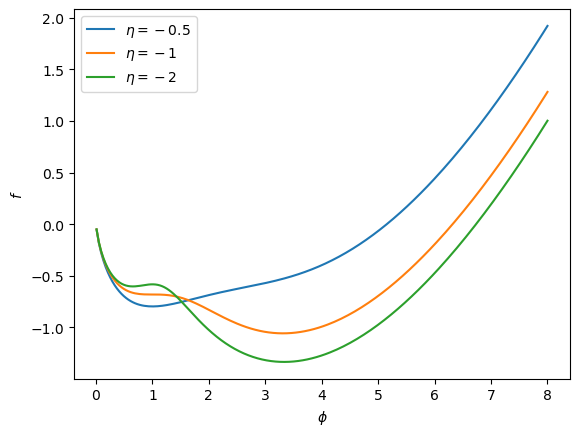

In [2]:
def get_f(phi, eta):
    def func_ln_v(phi, eta):
        return np.log(get_v_XY(phi, eta))
    
    int0, err = integrate.quad(func_ln_v, 0, phi, args=(eta))
    return phi * (np.log(phi) - 1) + int0


phi_arr = np.linspace(0.01, 8, 200)


for eta in [-0.5, -1, -2]:
    f_arr = np.zeros_like(phi_arr)
    for i, phi in enumerate(phi_arr):
        f_arr[i] = get_f(phi, eta)
    plt.plot(phi_arr, f_arr, label=r"$\eta=%g$" % eta)
plt.legend()
plt.xlabel(r"$\phi$")
plt.ylabel(r"$f$")
plt.show()
plt.close()


## Condition for phase coexistence

For the coexisting of liquid and gas phases, we need
$$
\begin{align*}
\mu_A(\phi_A^l,\phi_B^l) - \mu_A(\phi_A^g, \phi_B^g) &= 0, \\
\mu_B(\phi_A^l,\phi_B^l) - \mu_B(\phi_A^g, \phi_B^g) &= 0, \\
 \left.R_A R_B\right|_g^l + \int_{\phi_A^g}^{\phi_A^l}\mathrm{d}\phi_A\left(\frac{1}{\phi_A}+\frac{v_{AA}'}{v_{AA}}\right)R_A +
\int_{\phi_B^g}^{\phi_B^l}\mathrm{d}\phi_B\left(\frac{1}{\phi_B}+\frac{v_{BB}'}{v_{BB}}\right)R_B &= 0,
\end{align*},
$$
where
$$
R_A(\phi_A) = \ln v_{BA}(\phi_A),\\
R_B(\phi_B) = \ln v_{AB}(\phi_B).
$$


In [3]:

def f_int_A(phi_A, eta_AA, eta_BA):
    v_AA = get_v_XY(phi_A, eta_AA)
    v_BA = get_v_XY(phi_A, eta_BA)
    v_AA_prime = get_dv_XY(v_AA, eta_AA)
    return (1/phi_A + v_AA_prime/v_AA) * np.log(v_BA)


def f_int_B(phi_B, eta_AB, eta_BB):
    v_AB = get_v_XY(phi_B, eta_AB)
    v_BB = get_v_XY(phi_B, eta_BB)
    v_BB_prime = get_dv_XY(v_BB, eta_BB)
    return (1/phi_B + v_BB_prime/v_BB) * np.log(v_AB)

def get_RA_RB(phi_A, phi_B, eta_BA, eta_AB):
    v_BA = get_v_XY(phi_A, eta_BA)
    v_AB = get_v_XY(phi_B, eta_AB)
    return np.log(v_BA) * np.log(v_AB)



## Free energy for the two-species case

For the two-species case, the pseudo-potential $\psi$ reads
$$\begin{align*}
\psi(R_A, R_B) &\equiv \psi_A(R_A) + \psi_B(R_B) + \psi_{AB}(R_A, R_B) \\
&= \int \mathrm{d} R_A \ln(\phi_A v_{AA}) +
\int \mathrm{d} R_B \ln(\phi_B v_{BB}) +
R_A R_B, \\
&= \int \mathrm{d}\phi_A\, \frac{\partial \ln L_{BA}}{\partial \phi_A} \ln (\phi_A L_{AA})
+ \int \mathrm{d}\phi_B\, \frac{\partial \ln L_{AB}}{\partial \phi_B} \ln (\phi_B L_{BB})
+ R_A R_B
\end{align*}
$$

-0.22574040438840476 0.010920724358468328


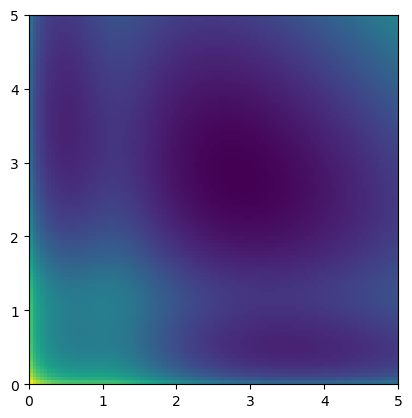

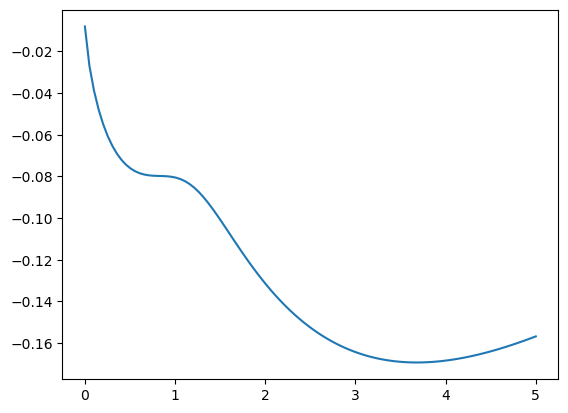

In [4]:
def get_psi(phi_A, phi_B, eta_AA, eta_AB, eta_BA, eta_BB):
    def f_int_RX(phi_X, eta_XX, eta_YX):
        v_XX = get_v_XY(phi_X, eta_XX)
        v_YX = get_v_XY(phi_X, eta_YX)
        v_YX_prime = get_dv_XY(v_YX, eta_YX)
        return v_YX_prime / v_YX * np.log(phi_X * v_XX)

    def f_int_A(phi_A, eta_AA, eta_BA):
        v_AA = get_v_XY(phi_A, eta_AA)
        v_BA = get_v_XY(phi_A, eta_BA)
        v_BA_prime = get_dv_XY(v_BA, eta_BA)
        return v_BA_prime / v_BA * np.log(phi_A * v_AA)

    RA_RB = get_RA_RB(phi_A, phi_B, eta_BA, eta_AB)
    intA, err = integrate.quad(f_int_A, rho_min, phi_A, args=(eta_AA, eta_BA))
    intB, err = integrate.quad(f_int_RX, rho_min, phi_B, args=(eta_BB, eta_AB))
    return intA + intB + RA_RB


eta_AA = -2
eta_BB = -2
eta_AB = 0.1
eta_BA = 0.1

rho_min = 1e-3
rA_max = 5
rB_max = 5

nA, nB = 100, 100
phi_A = np.linspace(rho_min, rA_max, nA)
phi_B = np.linspace(rho_min, rB_max, nB)

psi = np.zeros((nB, nA))

for j, rB in enumerate(phi_B):
    for i, rA in enumerate(phi_A):
        psi[j, i] = get_psi(rA, rB, eta_AA, eta_AB, eta_BA, eta_BB)

print(psi.min(), psi.max())
plt.imshow(psi, origin="lower", extent=[0, rA_max, 0, rB_max])

plt.show()
plt.close()

plt.plot(phi_A, psi[1])
plt.show()
plt.close()

If neglecting the nonreciprocal free energy density, we get
$$
f^\mathrm{eq}=\int \mathrm{d}\phi_A \ln v_{AA} + \int \mathrm{d}\phi_B \ln v_{BB} + \phi_A(\ln \phi_A - 1) + \phi_B(\ln \phi_B - 1) + \frac{1}{2} \left(
    \phi_A \ln v_{AB} + \phi_B \ln v_{BA}
\right)
$$
The corresponding pressure is
$$
p = \sum_{S} \left(
    \phi_S + \phi_S v_{SS} - \int \mathrm{d} \phi_S v_{SS} 
    \right) + \frac{1}{2}\phi_A\phi_B \left(
        \frac{\partial \ln v_{BA}}{\partial \phi_A} + \frac{\partial \ln v_{AB}}{\partial \phi_B}
    \right)
$$

In [5]:
def func(phi_arr, eta_AA, eta_AB, eta_BA, eta_BB):
    """ When phase equilibrium is reached, one should have [f1, f2, f3] = [0, 0, 0]

    Args:
        phi_arr (array): [phi_A_g, phi_B_g, phi_A_l, phi_B_l]
        eta_AA (float): _description_
        eta_AB (float): _description_
        eta_BA (float): _description_
        eta_BB (float): _description_
    """
    phi_A_g, phi_B_g, phi_A_l, phi_B_l = phi_arr
    f1 = get_mu_A(phi_A_l, phi_B_l, eta_AA, eta_AB) - get_mu_A(phi_A_g, phi_B_g, eta_AA, eta_AB)
    f2 = get_mu_B(phi_A_l, phi_B_l, eta_BA, eta_BB) - get_mu_B(phi_A_g, phi_B_g, eta_BA, eta_BB)

    int_A = integrate.quad(f_int_A, phi_A_g, phi_A_l, args=(eta_AA, eta_BA))
    int_B = integrate.quad(f_int_B, phi_B_g, phi_B_l, args=(eta_AB, eta_BB))
    f3 = get_RA_RB(phi_A_l, phi_B_l, eta_BA, eta_AB) - get_RA_RB(phi_A_g, phi_B_g, eta_BA, eta_AB) + int_A + int_B
    return [f1, f2, f3]

def func2(x_arr, eta_AA, eta_AB, eta_BA, eta_BB, rhoA_0, rhoB_0):
    """ When phase equilibrium is reached, one should have [f1, f2, f3, f4, f5] = [0, 0, 0, 0, 0]

    Args:
        x_arr (array): [phi_A_g, phi_B_g, phi_A_l, phi_B_l, s]
        eta_AA (float): _description_
        eta_AB (float): _description_
        eta_BA (float): _description_
        eta_BB (float): _description_
    """
    phi_A_g, phi_B_g, phi_A_l, phi_B_l, s = x_arr
    f1 = get_mu_A(phi_A_l, phi_B_l, eta_AA, eta_AB) - get_mu_A(phi_A_g, phi_B_g, eta_AA, eta_AB)
    f2 = get_mu_B(phi_A_l, phi_B_l, eta_BA, eta_BB) - get_mu_B(phi_A_g, phi_B_g, eta_BA, eta_BB)

    int_A, err = integrate.quad(f_int_A, phi_A_g, phi_A_l, args=(eta_AA, eta_BA))
    int_B, err = integrate.quad(f_int_B, phi_B_g, phi_B_l, args=(eta_AB, eta_BB))
    f3 = get_RA_RB(phi_A_l, phi_B_l, eta_BA, eta_AB) - get_RA_RB(phi_A_g, phi_B_g, eta_BA, eta_AB) + int_A + int_B

    f4 = (1-s) * phi_A_g + s * phi_A_l - rhoA_0
    f5 = (1-s) * phi_B_g + s * phi_B_l - rhoB_0
    return [f1, f2, f3, f4, f5]

def func3(x_arr, eta_AA, eta_AB, eta_BA, eta_BB, rhoA_0, rhoB_0):
    """ When phase equilibrium is reached, one should have [f1, f2, f3, f4, f5] = [0, 0, 0, 0, 0]

    Args:
        x_arr (array): [phi_A_1, phi_B_1, phi_A_2, phi_B_2, phi_A_3, phi_B_3, s, t]
        eta_AA (float): _description_
        eta_AB (float): _description_
        eta_BA (float): _description_
        eta_BB (float): _description_
    """
    phi_A_1, phi_B_1, phi_A_2, phi_B_2, phi_A_3, phi_B_3, s, t = x_arr
    
    mu_A_1 = get_mu_A(phi_A_1, phi_B_1, eta_AA, eta_AB)
    mu_A_2 = get_mu_A(phi_A_2, phi_B_2, eta_AA, eta_AB)
    mu_A_3 = get_mu_A(phi_A_3, phi_B_3, eta_AA, eta_AB)
    mu_B_1 = get_mu_B(phi_A_1, phi_B_1, eta_BA, eta_BB)
    mu_B_2 = get_mu_B(phi_A_2, phi_B_2, eta_BA, eta_BB)
    mu_B_3 = get_mu_B(phi_A_3, phi_B_3, eta_BA, eta_BB)

    f1 = mu_A_1 - mu_A_2
    f2 = mu_A_1 - mu_A_3
    f3 = mu_B_1 - mu_B_2
    f4 = mu_B_1 - mu_B_3

    RA_RB_1 = get_RA_RB(phi_A_1, phi_B_1, eta_BA, eta_AB)
    int_A, err = integrate.quad(f_int_A, phi_A_1, phi_A_2, args=(eta_AA, eta_BA))
    int_B, err = integrate.quad(f_int_B, phi_B_1, phi_B_2, args=(eta_AB, eta_BB))
    f5 = get_RA_RB(phi_A_2, phi_B_2, eta_BA, eta_AB) - RA_RB_1 + int_A + int_B

    int_A, err = integrate.quad(f_int_A, phi_A_1, phi_A_3, args=(eta_AA, eta_BA))
    int_B, err = integrate.quad(f_int_B, phi_B_1, phi_B_3, args=(eta_AB, eta_BB))
    f6 = get_RA_RB(phi_A_3, phi_B_3, eta_BA, eta_AB) - RA_RB_1 + int_A + int_B

    f7 = (1-s-t) * phi_A_1 + s * phi_A_2 + t * phi_A_3 - rhoA_0
    f8 = (1-s-t) * phi_B_1 + s * phi_B_2 + t * phi_B_3 - rhoB_0
    return [f1, f2, f3, f4, f5, f6, f7, f8]

def func2_eq(x_arr, eta_AA, eta_AB, eta_BA, eta_BB, rhoA_0, rhoB_0):
    """ When phase equilibrium is reached, one should have [f1, f2, f3, f4, f5] = [0, 0, 0, 0, 0]

    Args:
        phi_arr (array): [phi_A_g, phi_B_g, phi_A_l, phi_B_l, s]
        eta_AA (float): _description_
        eta_AB (float): _description_
        eta_BA (float): _description_
        eta_BB (float): _description_
    """

    phi_A_g, phi_B_g, phi_A_l, phi_B_l, s = x_arr
    f1 = get_mu_A(phi_A_l, phi_B_l, eta_AA, eta_AB) - get_mu_A(phi_A_g, phi_B_g, eta_AA, eta_AB)
    f2 = get_mu_B(phi_A_l, phi_B_l, eta_BA, eta_BB) - get_mu_B(phi_A_g, phi_B_g, eta_BA, eta_BB)

    # int_A, err = integrate.quad(f_int_A, phi_A_g, phi_A_l, args=(eta_AA, eta_BA))
    # int_B, err = integrate.quad(f_int_B, phi_B_g, phi_B_l, args=(eta_AB, eta_BB))
    int_A, err = integrate.quad(get_v_XY, phi_A_g, phi_A_l, args=(eta_AA, 0.7))
    int_B, err = integrate.quad(get_v_XY, phi_B_g, phi_B_l, args=(eta_BB, 0.7))
    vAA_g = get_v_XY(phi_A_g, eta_AA)
    vAA_l = get_v_XY(phi_A_l, eta_AA)
    vBB_g = get_v_XY(phi_B_g, eta_BB)
    vBB_l = get_v_XY(phi_B_l, eta_BB)
    vAB_prime_g = get_v_XY_prime(phi_B_g, eta_AB)
    vAB_prime_l = get_v_XY_prime(phi_B_l, eta_AB)
    vBA_prime_g = get_v_XY_prime(phi_A_g, eta_BA)
    vBA_prime_l = get_v_XY_prime(phi_A_l, eta_BA)

    f3_0 = phi_A_l * (1 + vAA_l) - phi_A_g * (1 + vAA_g) + phi_B_l * (1 + vBB_l) - phi_B_g * (1 + vBB_g)
    f3_1 = 0.5 * phi_A_l * phi_B_l * (vBA_prime_l + vAB_prime_l) - 0.5 * phi_A_g * phi_B_g * (vBA_prime_g + vAB_prime_g)
    f3 = f3_0 + f3_1 - int_A - int_B
    
    f4 = (1-s) * phi_A_g + s * phi_A_l - rhoA_0
    f5 = (1-s) * phi_B_g + s * phi_B_l - rhoB_0
    return [f1, f2, f3, f4, f5]


def func3_eq(x_arr, eta_AA, eta_AB, eta_BA, eta_BB, rhoA_0, rhoB_0):
    """ When phase equilibrium is reached, one should have [f1, f2, f3, f4, f5] = [0, 0, 0, 0, 0]

    Args:
        x_arr (array): [phi_A_1, phi_B_1, phi_A_2, phi_B_2, phi_A_3, phi_B_3, s, t]
        eta_AA (float): _description_
        eta_AB (float): _description_
        eta_BA (float): _description_
        eta_BB (float): _description_
    """
    def get_p1(phiA, phiB, etaAA, etaAB, etaBA, etaBB):
        p1A = phiA * (1 + get_v_XY(phiA, etaAA))
        p1B = phiB * (1 + get_v_XY(phiB, etaBB))
        p1AB = 0.5 * phiA * phiB * (get_v_XY_prime(phiA, etaBA) + get_v_XY_prime(phiB, etaAB))
        return p1A + p1B + p1AB
    
    def get_p_int(phi_A_1, phi_B_1, phi_A_2, phi_B_2, etaAA, etaBB):
        int_A, err = integrate.quad(get_v_XY, phi_A_1, phi_A_2, args=(etaAA, 0.7))
        int_B, err = integrate.quad(get_v_XY, phi_B_1, phi_B_2, args=(etaBB, 0.7))
        return int_A + int_B



    phi_A_1, phi_B_1, phi_A_2, phi_B_2, phi_A_3, phi_B_3, s, t = x_arr
    
    mu_A_1 = get_mu_A(phi_A_1, phi_B_1, eta_AA, eta_AB)
    mu_A_2 = get_mu_A(phi_A_2, phi_B_2, eta_AA, eta_AB)
    mu_A_3 = get_mu_A(phi_A_3, phi_B_3, eta_AA, eta_AB)
    mu_B_1 = get_mu_B(phi_A_1, phi_B_1, eta_BA, eta_BB)
    mu_B_2 = get_mu_B(phi_A_2, phi_B_2, eta_BA, eta_BB)
    mu_B_3 = get_mu_B(phi_A_3, phi_B_3, eta_BA, eta_BB)

    f1 = mu_A_1 - mu_A_2
    f2 = mu_A_1 - mu_A_3
    f3 = mu_B_1 - mu_B_2
    f4 = mu_B_1 - mu_B_3


    f5 = get_p1(phi_A_2, phi_B_2, eta_AA, eta_AB, eta_BA, eta_BB) \
        - get_p1(phi_A_1, phi_B_1, eta_AA, eta_AB, eta_BA, eta_BB) \
        - get_p_int(phi_A_1, phi_B_1, phi_A_2, phi_B_2, eta_AA, eta_BB)

    f6 = get_p1(phi_A_3, phi_B_3, eta_AA, eta_AB, eta_BA, eta_BB) \
        - get_p1(phi_A_1, phi_B_1, eta_AA, eta_AB, eta_BA, eta_BB) \
        - get_p_int(phi_A_1, phi_B_1, phi_A_3, phi_B_3, eta_AA, eta_BB)

    f7 = (1-s-t) * phi_A_1 + s * phi_A_2 + t * phi_A_3 - rhoA_0
    f8 = (1-s-t) * phi_B_1 + s * phi_B_2 + t * phi_B_3 - rhoB_0
    return [f1, f2, f3, f4, f5, f6, f7, f8]



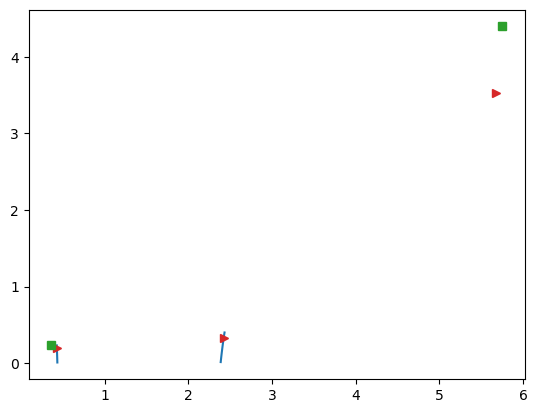

In [6]:
etaAA = -2
etaBB = -2
etaAB = -0.25
etaBA = -0.25

rhoA_0 = 1.25
rhoB_0 = 0.01

n = 40
rhoB0_arr = np.linspace(0.01, 0.3, n)
phi_A_l, phi_B_l, phi_A_g, phi_B_g = np.zeros((4, n))

x0 = [0.25, rhoB_0, 2.5, rhoB_0, 0.5]
for i, rhoB_0 in enumerate(rhoB0_arr):
    sol = optimize.root(func2, x0, args=(etaAA, etaAB, etaBA, etaBB, rhoA_0, rhoB_0))
    x = sol.x
    x0 = x
    phi_A_g[i] = x[0]
    phi_B_g[i] = x[1]
    phi_A_l[i] = x[2]
    phi_B_l[i] = x[3]

line, = plt.plot(phi_A_g, phi_B_g)
plt.plot(phi_A_l, phi_B_l, c=line.get_c())

rhoA_0 = 2.25
rhoB_0 = 1
x0 = [0.5, 0.25, 2.5, 0.4, 5, 3, 0.33, 0.33]
sol = optimize.root(func3, x0, args=(etaAA, etaAB, etaBA, etaBB, rhoA_0, rhoB_0))
x = sol.x

pA = [x[0], x[2], x[4]]
pB = [x[1], x[3], x[5]]

plt.plot(pA, pB, ">", c="tab:red")

# rhoA_0 = 2.25
# rhoB_0 = 1.
# x0 = [0.5, 0.25, 2.5, 0.4, 3, 1, 0.33, 0.33]
# sol = optimize.root(func3, x0, args=(etaAA, etaAB, etaBA, etaBB, rhoA_0, rhoB_0))
# x = sol.x

# pA = [x[0], x[2], x[4]]
# pB = [x[1], x[3], x[5]]

# plt.plot(pA, pB, ">")

# rhoB_0 = 0.01
# x0 = [0.25, rhoB_0, 2.5, rhoB_0, 0.5]
# for i, rhoB_0 in enumerate(rhoB0_arr):
#     sol = optimize.root(func2_eq, x0, args=(etaAA, etaAB, etaBA, etaBB, rhoA_0, rhoB_0))
#     x = sol.x
#     x0 = x
#     phi_A_g[i] = x[0]
#     phi_B_g[i] = x[1]
#     phi_A_l[i] = x[2]
#     phi_B_l[i] = x[3]

# line, = plt.plot(phi_A_g, phi_B_g)
# plt.plot(phi_A_l, phi_B_l, c=line.get_c())


rhoA_0 = 2
rhoB_0 = 1.5
x0 = [0.5, 0.5, 3, 2.5, 0.5]
sol = optimize.root(func2, x0, args=(etaAA, etaAB, etaBA, etaBB, rhoA_0, rhoB_0))
x = sol.x
plt.plot([x[0], x[2]], [x[1], x[3]], "s", c="tab:green")



plt.show()
plt.close()


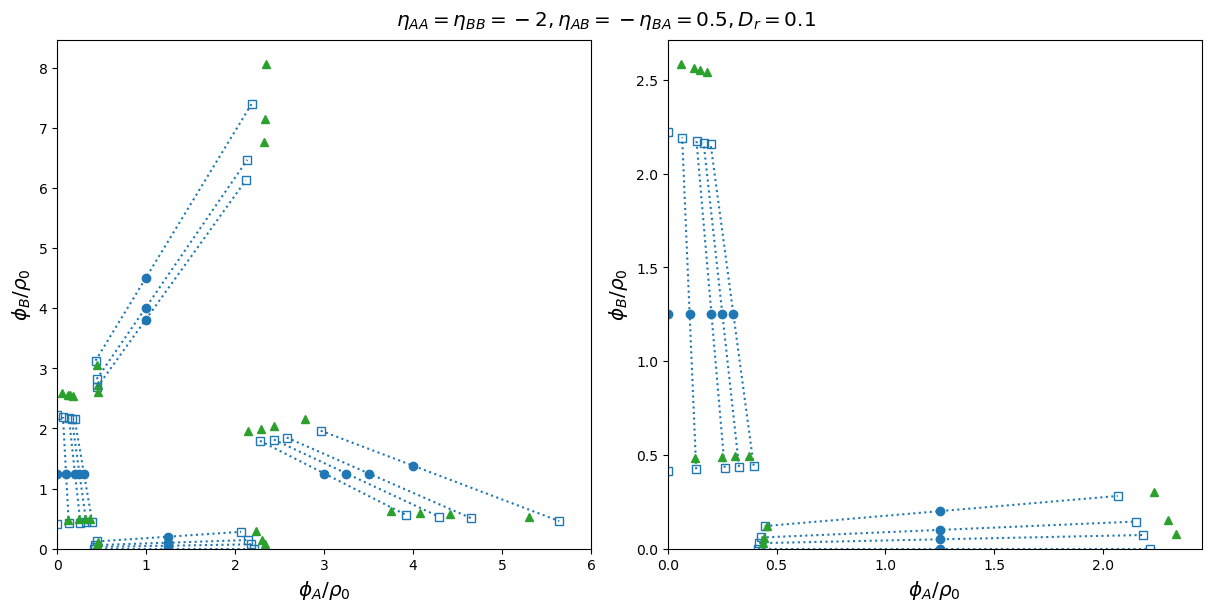

In [7]:
etaAA = -2
etaBB = -2
etaAB = 0.5
etaBA = -etaAB

# G + LA
center_G_LA = np.array([
        [12.5, 0],
        [12.5, 0.5],
        [12.5, 1],
        [12.5, 2],
        # [12.5, 3]
    ]) / 10
edge_G_LA = np.array([
        [[4.1229, 0], [22.1689, 0]],
        [[4.1984, 0.2967], [21.8290, 0.7313]],
        [[4.2891, 0.5983], [21.5045, 1.4470]],
        [[4.4534, 1.2062], [20.6741, 2.8125]],
        # [[4.6308, 1.7986], [19.6164, 4.1027]]
]) / 10


fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))
for i in range(edge_G_LA.shape[0]):
    center = center_G_LA[i]
    rho_g, rho_l = edge_G_LA[i]
    line, = ax1.plot(center[0], center[1], "o", c="tab:blue")
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], ":", c=line.get_c())
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], "s", fillstyle="none", c=line.get_c())

    line, = ax2.plot(center[0], center[1], "o", c="tab:blue")
    ax2.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], ":", c=line.get_c())
    ax2.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], "s", fillstyle="none", c=line.get_c())

    if i > 0:
        x0 = [rho_g[0], rho_g[1], rho_l[0], rho_l[1], 0.5]
        sol = optimize.root(func2, x0, args=(etaAA, etaAB, etaBA, etaBB, center[0], center[1]))
        x = sol.x
        ax1.plot([x[0], x[2]], [x[1], x[3]], "^", c="tab:green")
        ax2.plot([x[0], x[2]], [x[1], x[3]], "^", c="tab:green")


center_G_LB = np.array([[0, 12.5], [1, 12.5], [2, 12.5], [2.5, 12.5], [3, 12.5]]) / 10
edge_G_LB = np.array([
        [[0, 4.1531], [0, 22.1902]],
        [[1.3039, 4.2378], [0.6576, 21.9206]],
        [[2.6128, 4.3159], [1.3177, 21.7441]],
        [[3.2733, 4.3624], [1.6440, 21.6433]],
        [[3.9437, 4.4311], [1.9665, 21.5689]]
    ]) / 10
for i in range(edge_G_LB.shape[0]):
    center = center_G_LB[i]
    rho_g, rho_l = edge_G_LB[i]
    line, = ax1.plot(center[0], center[1], "o", c="tab:blue")
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], ":", c=line.get_c())
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], "s", fillstyle="none", c=line.get_c())

    line, = ax2.plot(center[0], center[1], "o", c="tab:blue")
    ax2.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], ":", c=line.get_c())
    ax2.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], "s", fillstyle="none", c=line.get_c())

    if i > 0:
        x0 = [rho_g[0], rho_g[1], rho_l[0], rho_l[1], 0.5]
        sol = optimize.root(func2, x0, args=(etaAA, etaAB, etaBA, etaBB, center[0], center[1]))
        x = sol.x
        ax1.plot([x[0], x[2]], [x[1], x[3]], "^", c="tab:green")
        ax2.plot([x[0], x[2]], [x[1], x[3]], "^", c="tab:green")


center_LB_LAB = np.array([[10, 45], [10, 40], [10, 38]]) / 10
edge_LB_LAB = np.array([
    [[4.3168, 31.2870], [21.8533, 73.9867]],
    [[4.4412, 28.2210], [21.3746, 64.7041]],
    [[4.5254, 26.9304], [21.2044, 61.2696]]
]) / 10

for i in range(edge_LB_LAB.shape[0]):
    center = center_LB_LAB[i]
    rho_g, rho_l = edge_LB_LAB[i]
    line, = ax1.plot(center[0], center[1], "o", c="tab:blue")
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], ":", c=line.get_c())
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], "s", fillstyle="none", c=line.get_c())

    if i > -1:
        x0 = [rho_g[0], rho_g[1], rho_l[0], rho_l[1], 0.5]
        sol = optimize.root(func2, x0, args=(etaAA, etaAB, etaBA, etaBB, center[0], center[1]))
        x = sol.x
        ax1.plot([x[0], x[2]], [x[1], x[3]], "^", c="tab:green")


# LAB + LA
center_LAB_LA = np.array([
    # [130/4, 40/4],
    [120/4, 50/4],
    [130/4, 50/4],
    [140/4, 50/4],
    [160/4, 55/4],
    # [45, 15],
    # [47, 19],
    # [60, 20]
    ]) / 10
edge_LAB_LA = np.array([
    # [[90.3333/4, 70.2929/4], [152.7865/4, 22.8993/4]],
    [[91.1910/4, 71.7885/4], [156.7620/4, 22.5345/4]], 
    [[97.4319/4, 72.6223/4], [171.5426/4, 21.3663/4]],
    [[103.2168/4, 73.9762/4], [185.9900/4, 20.3843/4]],
    [[118.4965/4, 78.5602/4], [225.7040/4, 18.3693/4]],
    # [[36.65, 19.], [66.4, 4.578]],
    # [[41.6492, 21.3472], [88.2805, 4.2819]],
    # [[53.6089, 22.2076], [108.7682, 4.1077]]
]) / 10

for i in range(edge_LAB_LA.shape[0]):
    center = center_LAB_LA[i]
    rho_g, rho_l = edge_LAB_LA[i]
    line, = ax1.plot(center[0], center[1], "o", c="tab:blue")
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], ":", c=line.get_c())
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], "s", fillstyle="none", c=line.get_c())

    if i > -1:
        x0 = [rho_g[0], rho_g[1], rho_l[0], rho_l[1], 0.5]
        sol = optimize.root(func2, x0, args=(etaAA, etaAB, etaBA, etaBB, center[0], center[1]))
        x = sol.x
        ax1.plot([x[0], x[2]], [x[1], x[3]], "^", c="tab:green")
        # ax.plot([x[0], x[2]], [x[1], x[3]], ":", c="tab:green")


ax1.set_xlim(0, 6)
ax1.set_ylim(0)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax1.set_xlabel(r"$\phi_A/\rho_0$", fontsize="x-large")
ax1.set_ylabel(r"$\phi_B/\rho_0$", fontsize="x-large")
ax2.set_xlabel(r"$\phi_A/\rho_0$", fontsize="x-large")
ax2.set_ylabel(r"$\phi_B/\rho_0$", fontsize='x-large')

fig.suptitle(r"$\eta_{AA}=\eta_{BB}=-2, \eta_{AB}=-\eta_{BA}=0.5, D_r=0.1$", fontsize="x-large")
plt.show()
plt.close()



In [10]:
rhoA_0 = 5/20
rhoB_0 = 1
x0 = [0.3, 0.43, 0.5, 2.2, 0.5]
sol = optimize.root(func2, x0, args=(etaAA, etaAB, etaBA, etaBB, rhoA_0, rhoB_0))
x = sol.x
print(x)

rhoA_0 = 7.6525/10
rhoB_0 = 10.5675/10
x0 = [0.12, 0.39, 1.17, 2.35, 0.5]
sol = optimize.root(func2, x0, args=(etaAA, etaAB, etaBA, etaBB, rhoA_0, rhoB_0))
x = sol.x
print(x)

[0.2867309  0.49119514 0.1376073  2.55688951 0.24631178]
[  0.80530366   0.81531082   0.80515102   0.81623087 262.404791  ]


C:\Users\Yu\AppData\Local\Temp\ipykernel_23548\3897220216.py:32: RuntimeWarning: invalid value encountered in log
  return np.log(rho_B * v_B)
C:\Users\Yu\AppData\Local\Temp\ipykernel_23548\3742310385.py:35: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  int_B, err = integrate.quad(f_int_B, phi_B_g, phi_B_l, args=(eta_AB, eta_BB))
C:\Users\Yu\AppData\Local\Temp\ipykernel_23548\3742310385.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_A, err = integrate.quad(f_int_A, phi_A_g, phi_A_l, args=(eta_AA, eta_BA))
C:\Users\Yu\AppData\Local\Temp\ipykernel_23548\3742310385.py:35: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_B, err = integrate.quad(f_int_B, phi_B_g, phi_B_l, args=(eta_AB, eta_BB))
